# Twitter Sentiment Analysis Pre-Trained


This notebook uses pretrained models (found in the /models dir. And downloadable via the /src/models/download_models.sh script.


In [3]:
!bash ../src/models/download_models.sh

Output file downloaded to ../../models/encoder.pkl
Output file downloaded to ../../models/model.h5
Output file downloaded to ../../models/model.w2v
Output file downloaded to ../../models/tokenizer.pkl
Kernel log downloaded to ../../models/twitter-sentiment-analysis.log 


In [16]:
# Download data
!bash ../src/data/download_dataset.sh

In [4]:
# install lab dependencies
!pip install --upgrade pip
!pip install gensim --upgrade
!pip install pandas --upgrade
!pip install nltk --upgrade
!pip install sklearn

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.1)
Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4.5)


In [36]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# TensorFLow
# import tensorflow as tf is not working
import tensorflow 
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [41]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"
MODELS_DIR = "../../models/"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [8]:
dataset_path = os.path.join("..","data","raw", "training.1600000.processed.noemoticon.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../data/raw/training.1600000.processed.noemoticon.csv


In [9]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [10]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [11]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [12]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 443 ms, sys: 16.7 ms, total: 459 ms
Wall time: 458 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

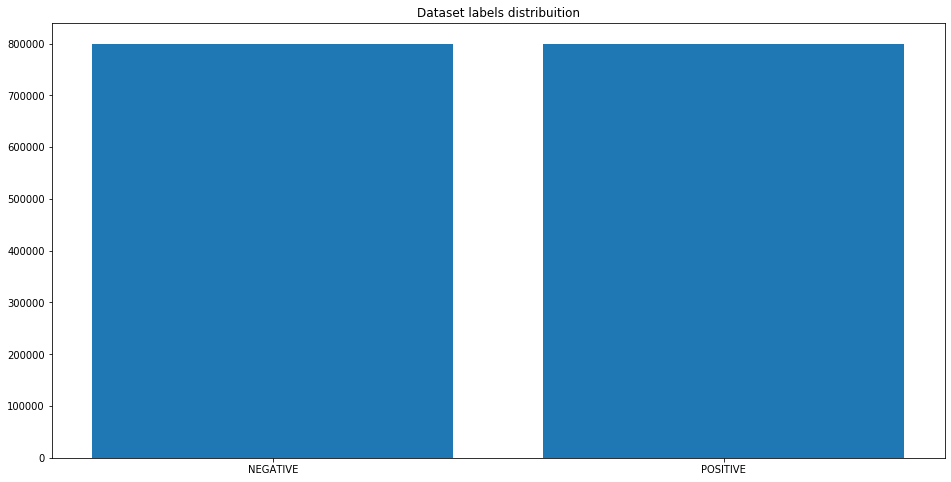

In [13]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [14]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [15]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 35 s, sys: 126 ms, total: 35.1 s
Wall time: 35.1 s


### Split train and test

In [21]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [24]:
w2v_model.build_vocab(documents)

2020-02-25 22:36:48,413 : INFO : collecting all words and their counts
2020-02-25 22:36:48,415 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-02-25 22:36:48,435 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-02-25 22:36:48,451 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-02-25 22:36:48,469 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-02-25 22:36:48,490 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-02-25 22:36:48,509 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-02-25 22:36:48,530 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-02-25 22:36:48,551 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-02-25 22:36:48,571 : INFO : PROGRESS: at s

2020-02-25 22:36:49,953 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-02-25 22:36:49,972 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-02-25 22:36:50,004 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-02-25 22:36:50,032 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-02-25 22:36:50,052 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-02-25 22:36:50,073 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-02-25 22:36:50,097 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-02-25 22:36:50,121 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-02-25 22:36:50,146 : INFO : PROGRESS: at sentence #800000, processed 577088

In [42]:
w2v_model = gensim.models.word2vec.Word2Vec.load(os.path.join(MODELS_DIR, WORD2VEC_MODEL))

2020-02-25 22:50:08,735 : INFO : loading Word2Vec object from ../../models/model.w2v
2020-02-25 22:50:09,324 : INFO : loading wv recursively from ../../models/model.w2v.wv.* with mmap=None
2020-02-25 22:50:09,325 : INFO : setting ignored attribute vectors_norm to None
2020-02-25 22:50:09,326 : INFO : loading vocabulary recursively from ../../models/model.w2v.vocabulary.* with mmap=None
2020-02-25 22:50:09,326 : INFO : loading trainables recursively from ../../models/model.w2v.trainables.* with mmap=None
2020-02-25 22:50:09,327 : INFO : setting ignored attribute cum_table to None
2020-02-25 22:50:09,327 : INFO : loaded ../../models/model.w2v


In [34]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-02-25 22:45:29,695 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5732780694961548),
 ('loves', 0.5623787045478821),
 ('loved', 0.5373271703720093),
 ('amazing', 0.5026600360870361),
 ('adore', 0.4942743480205536),
 ('looove', 0.47235167026519775),
 ('awesome', 0.4598265290260315),
 ('lovee', 0.45823752880096436),
 ('loveee', 0.4531649351119995),
 ('loooove', 0.44260522723197937)]

### Build Model

In [63]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join(MODELS_DIR,KERAS_MODEL))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Predict

In [1]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [2]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [3]:
predict("I love the music")

NameError: name 'time' is not defined

In [68]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.010753682814538479,
 'elapsed_time': 0.07245063781738281}

In [69]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.2742375433444977,
 'elapsed_time': 0.07145833969116211}